In [1]:
from definitions import *
from xmca.array import MCA
from xmca.xarray import xMCA
from scipy.optimize import basinhopping, minimize, brute, shgo
from numpy.typing import ArrayLike

%load_ext autoreload
%autoreload 2

In [2]:
exp_wind = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, False, 'anomaly', 'JJA')
exp_T = ClusteringExperiment('ERA5', 'Temperature', '2m', 'box_-25_60_32_72', 't', None, None, None, None, False, 'anomaly', 'JJA')
da_wind = exp_wind.open_da()
da_T = exp_T.open_da()

In [3]:
X, da_wind = exp_wind.prepare_for_clustering()
Y, da_T = exp_T.prepare_for_clustering()

X = exp_wind.pca_transform(X, 150)
Y = exp_T.pca_transform(Y, 100)

# EOFs

# REOFS / FA

# EEOFs

# POPs

# $T_1$ OPPs

In [103]:
n_pcas = 150
lag_max = 90
autocorrs = []
for i in range(lag_max + 1):
    autocorrs.append(
        np.cov(X[i:], np.roll(X, i, axis=0)[i:], rowvar=False)[
            n_pcas:, :n_pcas
        ]
    )

autocorrs = np.asarray(autocorrs)
M = np.sum(autocorrs + autocorrs.transpose((0, 2, 1)),axis=0)

invC0 = linalg.inv(autocorrs[0])
eigenvals, eigenvecs = linalg.eigh(0.5 * invC0 @ M)
OPPs = autocorrs[0] @ eigenvecs.T
idx = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx]
OPPs = OPPs[idx]
results = {
    "eigenvals": eigenvals,
    "OPPs": OPPs,
}

[autoreload of definitions failed: Traceback (most recent call last):
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/storage/homefs/hb22g102/per

In [ ]:
OPPs_T1_da = exp_wind.to_dataarray(OPPs, da_wind, 150)

(<Figure size 1950x975 with 10 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fd7d114ae50>)

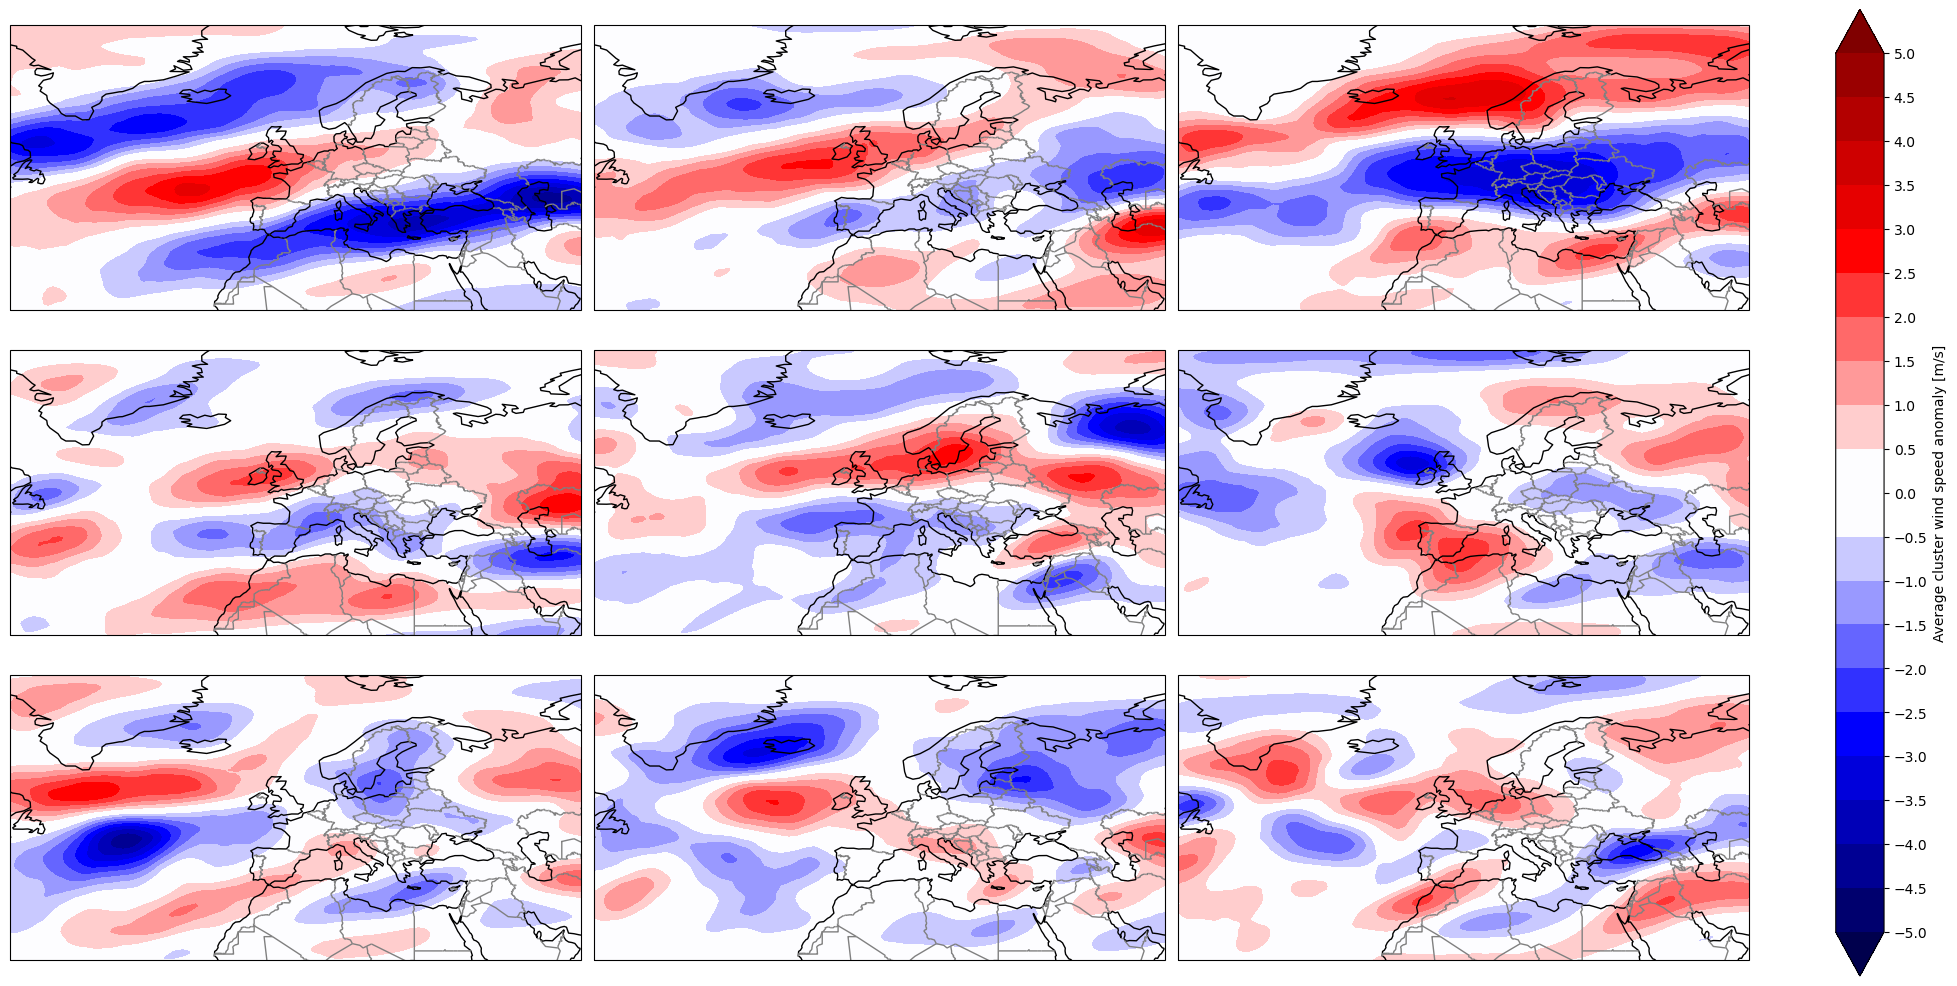

In [ ]:
clusterplot(3, 3, [OPPs_T1_da[i] for i in range(9)], 11, 5, clabels=None, contours=False, cbar_ylabel='Average cluster wind speed anomaly [m/s]')

# $T_2$ OPPs

In [99]:
n_pcas = 150
lag_max = 90
autocorrs = []

C0sqrt = linalg.sqrtm(autocorrs[0])
C0minushalf = linalg.inv(C0sqrt)
basis = linalg.orth(C0minushalf)

def T2(x) -> float:
    normxsq = linalg.norm(x) ** 2
    factor1 = x.T @ C0minushalf @ autocorrs @ C0minushalf @ x
    return np.sum(factor1 ** 2) / normxsq ** 2

def minus_T2(x) -> float:
    return - T2(x)

def T2_gradient(x) -> ArrayLike:
    normxsq = linalg.norm(x) ** 2
    factor1 = x.T @ C0minushalf @ autocorrs @ C0minushalf @ x
    numerator = np.sum((factor1)[:, None] * ((C0minushalf @ (autocorrs + autocorrs.transpose((0, 2, 1))) @ C0minushalf) @ x), axis=0)
    return numerator / normxsq ** 2 - 4 * T2(x) * x / normxsq ** 3

def minus_T2_gradient(x) -> ArrayLike:
    return - T2_gradient(x)

def norm0(x) -> float:
    return 10 - linalg.norm(x) ** 2

def jac_norm0(x) -> ArrayLike:
    return - 2 * x

In [100]:
Id = np.eye(n_pcas)
proj = Id.copy()
OPPs_T2 = []
numsuc = 0
i = 0
while numsuc < 10:
    xmin, xmax = np.amin(basis, axis=0), np.amax(basis, axis=0)
    x0 = xmin + (xmax - xmin) * np.random.rand(len(xmax))
    t = timer.perf_counter()
    res = minimize(minus_T2, x0, jac=minus_T2_gradient, method='SLSQP', constraints={'type': 'ineq', 'fun': norm0, 'jac': jac_norm0})
    print(f'{i=}, {res.success}, T2={-(res.fun):.2f}, norm={linalg.norm(res.x):.2f}, time={timer.perf_counter() - t:.2f}s')
    if res.success:
        unit_x = res.x / linalg.norm(res.x)
        OPPs_T2.append(C0sqrt @ unit_x)
        proj = Id - np.outer(unit_x, unit_x)
        autocorrs = proj @ autocorrs @ proj
        C0minushalf = proj @ C0minushalf @ proj
        numsuc += 1
    i += 1


i=0, True, T2=7.17, norm=3.16, time=1.64s
i=1, True, T2=5.06, norm=3.16, time=1.24s
i=2, False, T2=4.49, norm=3.16, time=4.14s
i=3, True, T2=4.50, norm=3.16, time=2.96s
i=4, True, T2=4.47, norm=3.16, time=1.34s
i=5, True, T2=4.13, norm=3.16, time=2.39s
i=6, True, T2=3.65, norm=3.16, time=1.94s
i=7, True, T2=3.48, norm=3.16, time=1.27s
i=8, True, T2=3.10, norm=3.16, time=2.32s
i=9, False, T2=3.03, norm=3.16, time=2.57s
i=10, False, T2=3.03, norm=3.16, time=2.53s
i=11, False, T2=2.75, norm=3.16, time=2.52s
i=12, True, T2=3.03, norm=3.16, time=2.26s
i=13, False, T2=2.75, norm=3.16, time=2.51s
i=14, False, T2=2.67, norm=3.16, time=2.51s
i=15, False, T2=2.75, norm=3.16, time=2.54s
i=16, True, T2=2.75, norm=3.16, time=1.78s


In [101]:
OPPs_T2_da = exp_wind.to_dataarray(np.asarray(OPPs_T2), da_wind, 150)

(<Figure size 1950x975 with 10 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7fd7cbebae50>)

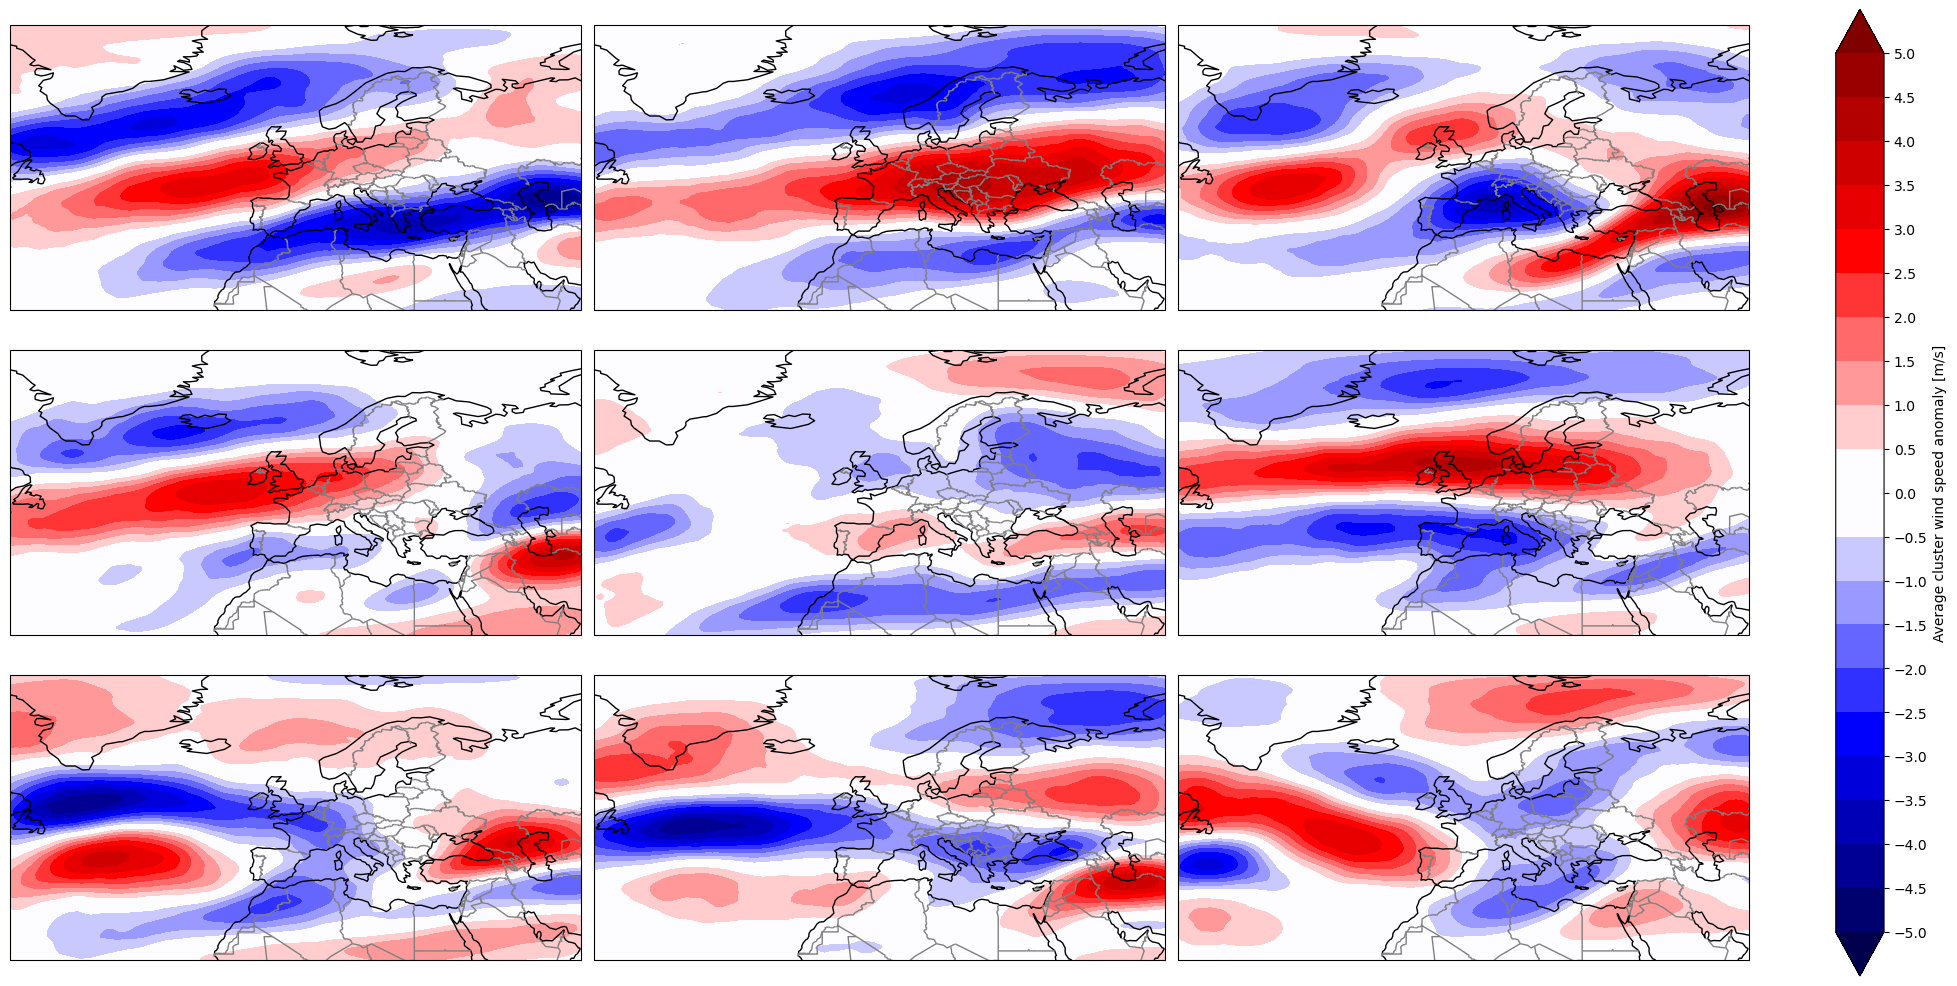

In [102]:
clusterplot(3, 3, [OPPs_T2_da[i] for i in range(9)], 11, 5, clabels=None, contours=False, cbar_ylabel='Average cluster wind speed anomaly [m/s]')

# DMFs

# CCA / MCA

In [62]:
pca = MCA(X, Y)
pca.normalize()
pca.solve()

In [48]:
svals_rule_n = pca.rule_n(n_runs=1000)

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [51]:
q99 = np.quantile(svals_rule_n, 0.99, axis=1)

In [52]:
np.argmax(svals < q99)

25

In [66]:
eofs = pca.eofs(n=80, scaling='max')
pcs = pca.pcs(n=80, scaling='max')

In [69]:
eofs['left'].shape

(150, 80)

In [75]:
eofs_realspace = {
    'left': exp_wind.to_dataarray(eofs['left'].T, da_wind, 150),
    'right': exp_T.to_dataarray(eofs['right'].T, da_T, 100),
}

In [ ]:
eofs_realspace

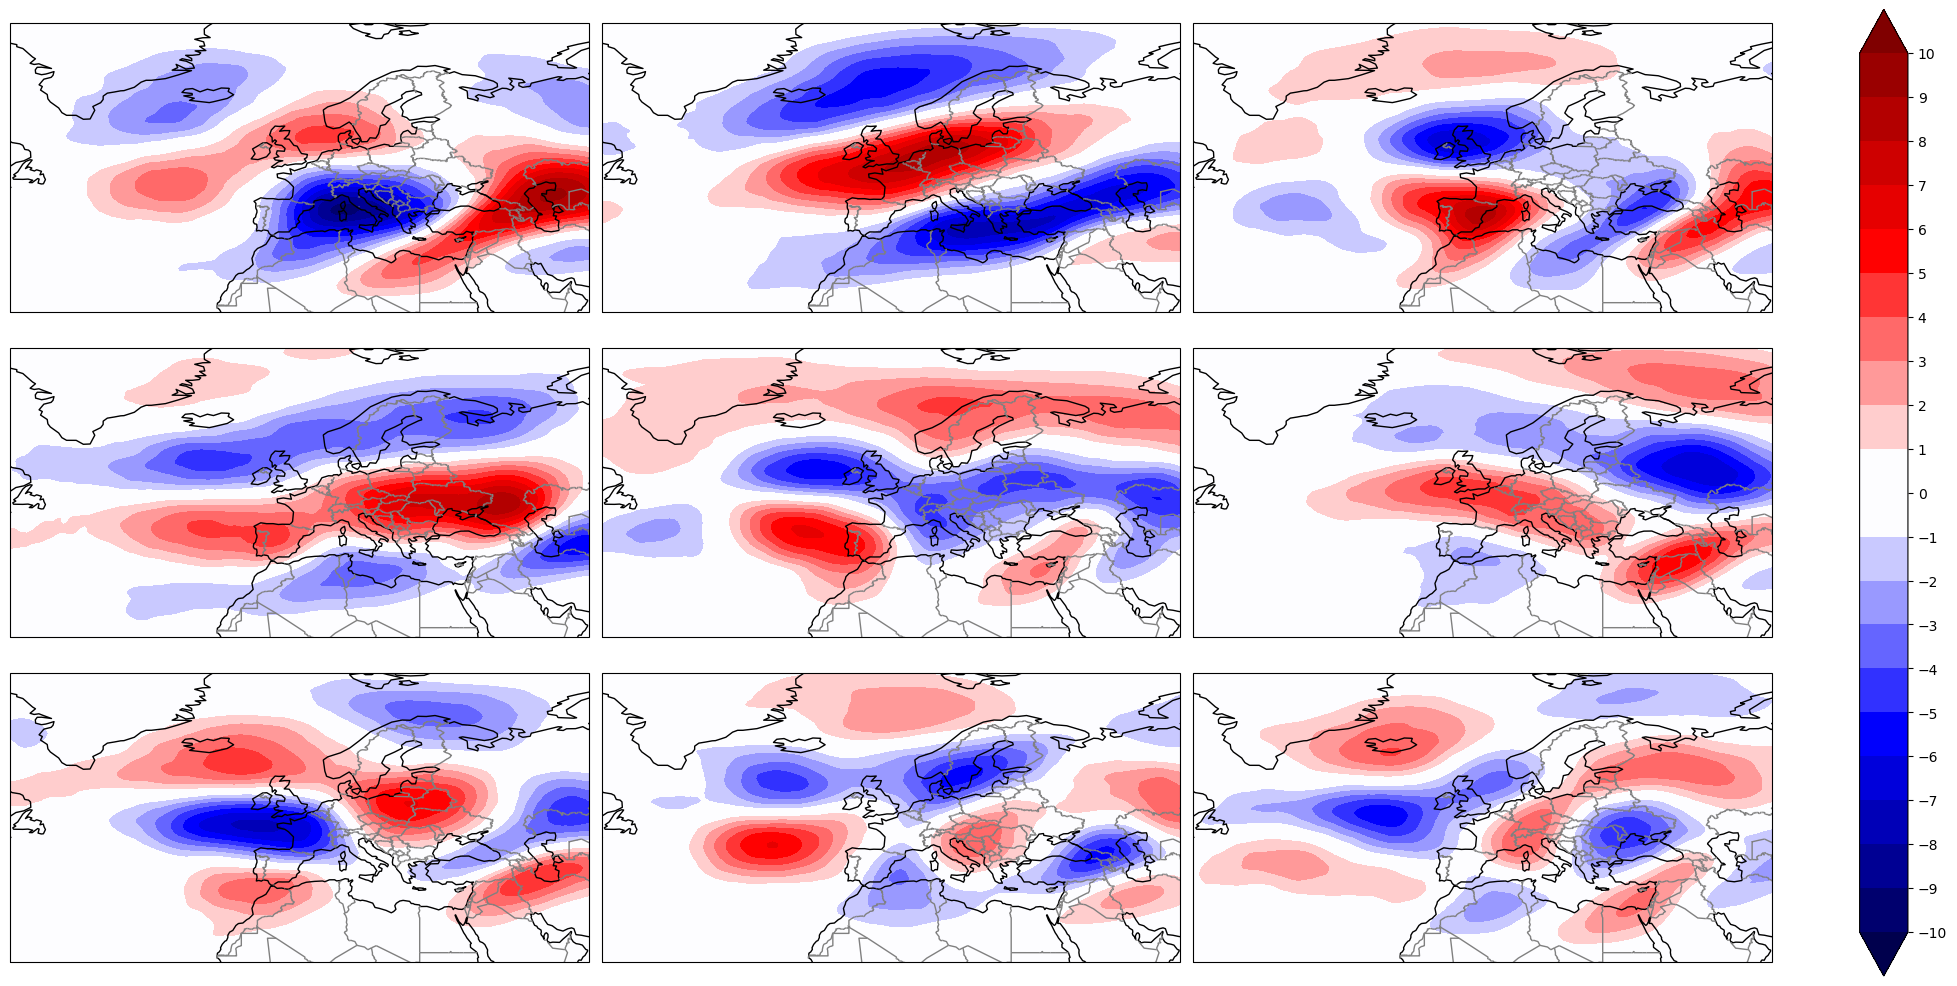

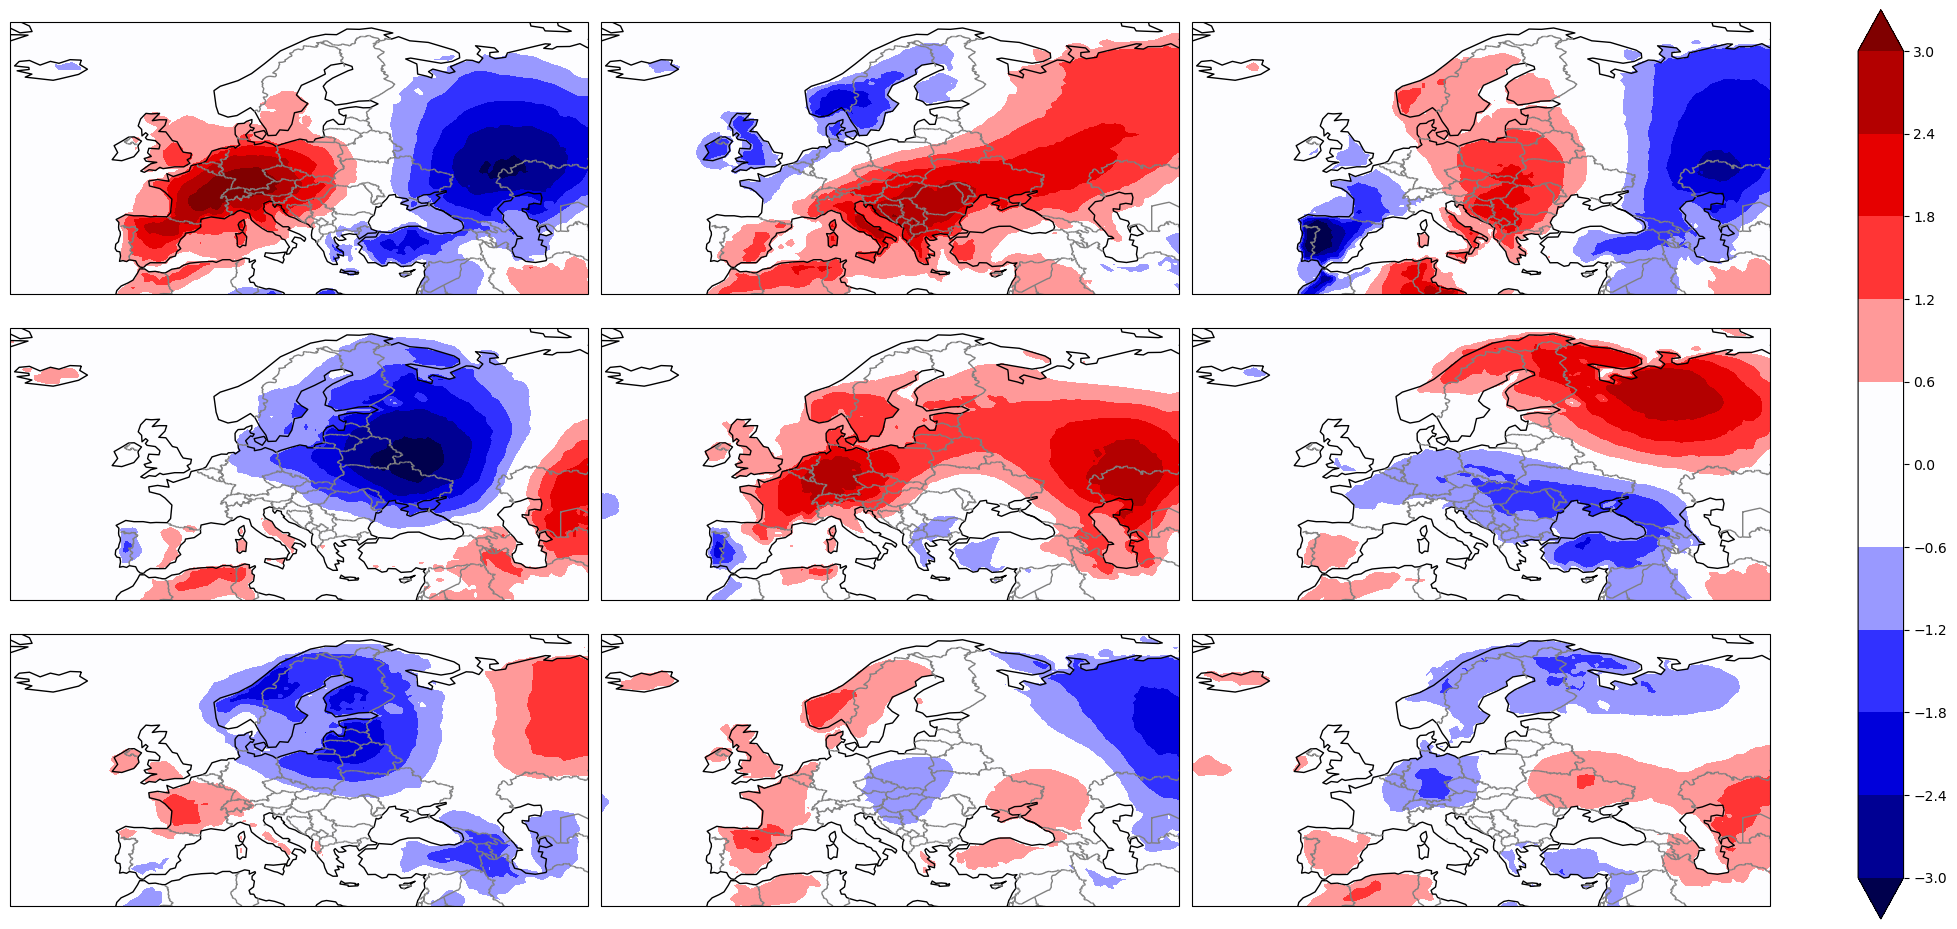

In [79]:
to_plot = {key : [eofs_realspace[key].isel(mode=i) for i in range(9)] for key in eofs}

fig, axes, cbar = clusterplot(3, 3, to_plot['left'], 11, 10, clabels=None, contours=False)
fig, axes, cbar = clusterplot(3, 3, to_plot['right'], 6, 3, clabels=None, contours=False)

# to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
# levels = 12
# levels2 = int(levels / 2)
# colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
# linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
# for ax, toplt, eigenval in zip(axes, to_plot, eigenvals):
#     toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)
#     ax.set_title(f'{eigenval:.2f}')